# Analyzing Consumer Behavior

In this analysis, we delve into the fascinating world of retail data to unlock valuable insights for businesses. Market Basket Analysis is a powerful technique that allows retailers to understand customer behavior, identify item associations, and offer personalized recommendations.

The primary goal of this notebook is to help retailers optimize their product catalog, enhance marketing strategies, and ultimately improve customer engagement and satisfaction. By mining transaction data and applying the Apriori algorithm, we aim to uncover hidden patterns in customer purchasing habits.

## Import libraries

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Data Preprocessing
- Start loading the dataset and explore it to get a better understanding of the data.

In [2]:
# Import the dataset
ds = pd.read_excel("assets/data/Analyzing_Consumer_Behaviour_Data.xlsx")

# Explore the dataset
ds.head(200)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
195,536389,CHRISTMAS LIGHTS 10 REINDEER,6,2010-12-01 10:03:00,8.50,12431.0,Australia
196,536389,VINTAGE UNION JACK CUSHION COVER,8,2010-12-01 10:03:00,4.95,12431.0,Australia
197,536389,VINTAGE HEADS AND TAILS CARD GAME,12,2010-12-01 10:03:00,1.25,12431.0,Australia
198,536389,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,12431.0,Australia


- Check for missing values and handle them appropriately. Remove rows with missing values if necessary, or impute them based on the data type and distribution of the data or context.

In [3]:
# Check for missing values
ds.isnull().sum()

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
dtype: int64

- Remove duplicates if any exist in the dataset.

In [4]:
# Drop the rows with missing values
ds.dropna(axis=0, inplace=True)

# Verify if the rows with missing values were dropped
ds.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
Country       0
dtype: int64

- Convert the "Date" column to a datetime format. (Use the `pd.to_datetime()` function)

In [5]:
# Convert the "Date" column to a datetime format
ds["Date"] = pd.to_datetime(ds["Date"])

- Verity the data type of columns and convert them to the appropriate data types if necessary.

In [6]:
# Verify the data type of columns   
ds.dtypes

BillNo                object
Itemname              object
Quantity               int64
Date          datetime64[ns]
Price                float64
CustomerID           float64
Country               object
dtype: object

## Exploratory Data Analysis (EDA)

- Conduct exploratory data analysis to gain better insights into the dataset, use libraries like `matplotlib` and `seaborn` to create visualizations.
- Plot histograms and box plots to understand the distribution of numerical variables like 'Quantity' and 'Price.'

In [ ]:
# Visualize data distribution (Quantity and Price)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ds['Quantity'], bins=20, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(ds['Price'], bins=20, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Examine trends in sales data over time by plotting a time series of sales. Extract month and year from the 'Date' column and group the data by month and year to calculate total sales.

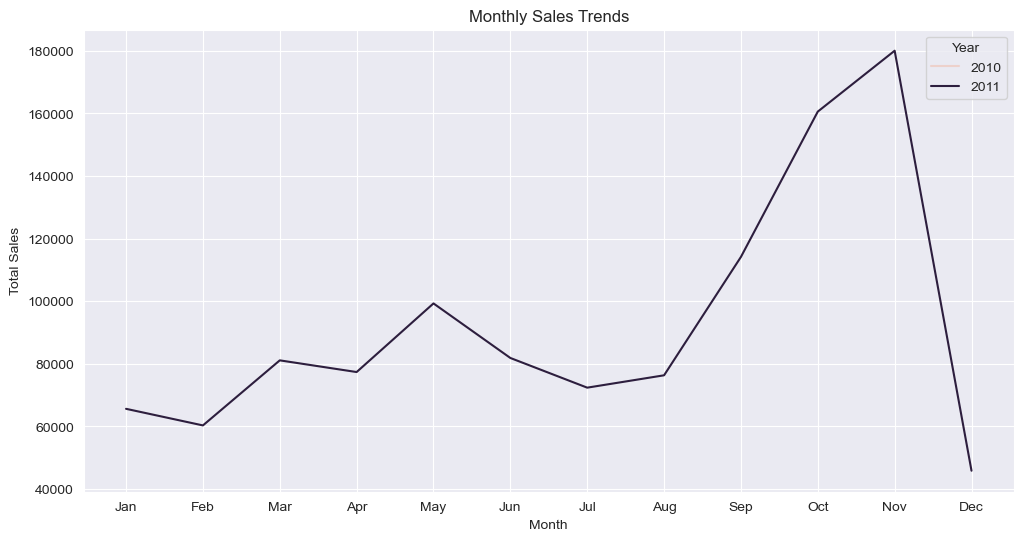

In [8]:
# Visualize sales trends over time
ds['Date'] = pd.to_datetime(ds['Date'])  # Convert 'Date' column to datetime

# Extract month and year from the 'Date' column
ds['Year'] = ds['Date'].dt.year
ds['Month'] = ds['Date'].dt.month

# Group data by month and calculate total sales
monthly_sales = ds.groupby(['Year', 'Month'])['Price'].sum().reset_index()

# Plot sales trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Price', hue='Year')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title='Year')
plt.show()

- Create bar charts to visualize categorical variables like 'Country'.

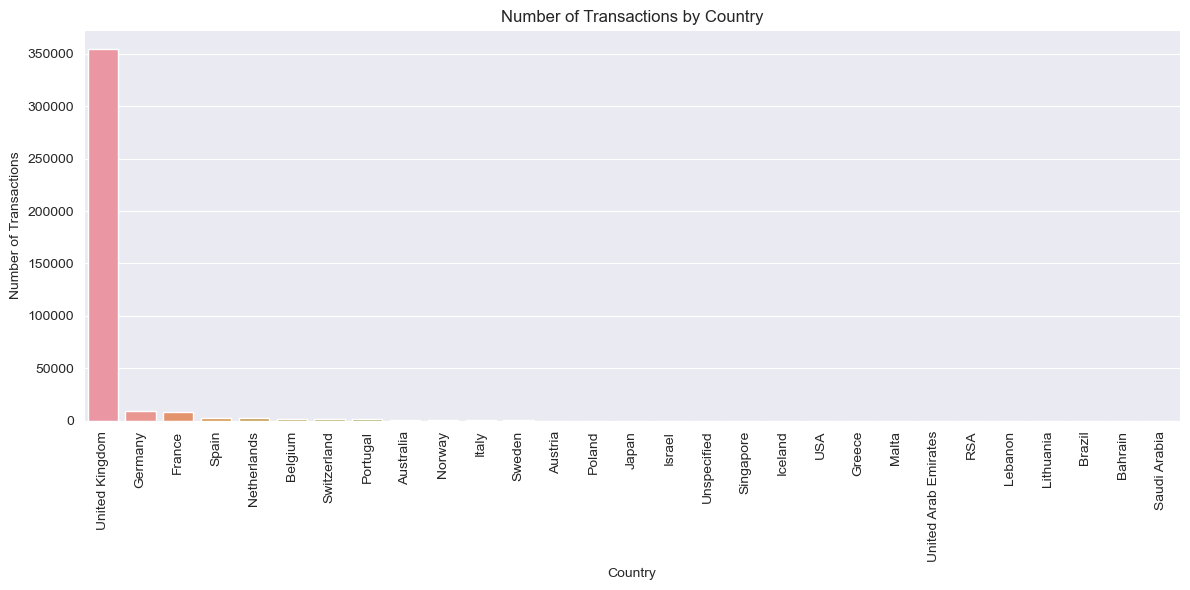

In [9]:
# Visualize the number of transactions by country
plt.figure(figsize=(12, 6))
sns.barplot(x=ds['Country'].value_counts().index, y=ds['Country'].value_counts().values)
plt.title('Number of Transactions by Country')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

## Transaction Data Preparation

- To perform Market Basket Analysis, you need to transform your data into transaction-level format.
- Group your data by 'BillNo' and 'Itemname,' creating a transaction dataset with items as columns and binary values (1 if the item was purchased, 0 if not) in the cells.
- Use the `pd.crosstab()` function to create a transaction dataset.
- Use the `mlxtend.preprocessing.TransactionEncoder()` function to encode the transaction dataset.
- Transaction dataset should have 'BillNo' as the index and items as columns.

In [10]:
# Group data by 'BillNo' and 'Itemname'
transaction_data = pd.crosstab(index=ds['BillNo'], columns=ds['Itemname'])

# Convert the pivot table to a binary transaction dataset
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

transaction_data = transaction_data.applymap(encode_units)

# Verify the transaction dataset
transaction_data.head(10)

Itemname,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
BillNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Association Rule Mining

- Use the Apriori algorithm to perform association rule mining on your transaction dataset. You can use libraries like mlxtend in Python.
- Start by setting a low support threshold (e.g., 0.01) and confidence threshold (e.g., 0.5) to generate initial rules.
- Experiment with different values of support and confidence thresholds to generate more rules.
- Generate frequent item sets and association rules. You'll get results with support, confidence, and lift values.

In [11]:
# Convert the sparse matrix back to a pandas DataFrame
sparse_transaction_data = csc_matrix(transaction_data.values)
sparse_transaction_df = pd.DataFrame.sparse.from_spmatrix(sparse_transaction_data, columns=transaction_data.columns)

# Convert the dataframe to boolean values with SparseDtype
sparse_transaction_df = sparse_transaction_df.astype(pd.SparseDtype(bool))

# Apply the Apriori algorithm
# Set the minimum support and confidence threshold
min_support = 0.01 # Set your desired support threshold
min_confidence = 0.5 # Set your desired confidence threshold

# Generate frequent item sets
frequent_itemsets = apriori(sparse_transaction_df, min_support=min_support, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=min_confidence)

# Display association rules with support, confidence, and lift
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 72 RETROSPOT CAKE CASES),0.010075,0.543027,9.942534
1,(PACK OF 72 RETROSPOT CAKE CASES),(60 CAKE CASES DOLLY GIRL DESIGN),0.010075,0.184476,9.942534
2,(72 SWEETHEART FAIRY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.011617,0.439583,12.673257
3,(60 TEATIME FAIRY CAKE CASES),(72 SWEETHEART FAIRY CAKE CASES),0.011617,0.334921,12.673257
4,(PACK OF 60 DINOSAUR CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.011782,0.419608,12.097361
...,...,...,...,...,...
933,"(LUNCH BAG PINK POLKADOT, LUNCH BAG CARS BLUE)","(LUNCH BAG BLACK SKULL., LUNCH BAG RED RETROS...",0.010461,0.451306,16.135981
934,(LUNCH BAG BLACK SKULL.),"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA...",0.010461,0.182868,12.166425
935,(LUNCH BAG RED RETROSPOT),"(LUNCH BAG BLACK SKULL., LUNCH BAG PINK POLKA...",0.010461,0.150079,10.606555
936,(LUNCH BAG PINK POLKADOT),"(LUNCH BAG BLACK SKULL., LUNCH BAG RED RETROS...",0.010461,0.207877,14.634412


## Rule Evaluation and Selection

- Evaluate the generated rules based on support, confidence, and lift.
- Filter and select the most relevant and interesting rules based on your business objectives.
- Use `pandas` to filter rules based on threshold values.

In [12]:
# Assess the rules with minimum support, confidence, and lift to identify meaningful associations
min_lift = 1.0 # Set your desired lift threshold

# Filter rules based on lift threshold
filtered_rules = rules[
    (rules['support'] >= min_support) &
    (rules['confidence'] >= min_confidence) &
    (rules['lift'] >= min_lift)
    ]

# Sort and select relevant rules
# Depending on your business objective, you may sort the rules by different metrics
sorted_rules = filtered_rules.sort_values(by='lift', ascending=False)

# Display the top 10 rules
sorted_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
529,(REGENCY SUGAR BOWL GREEN),(REGENCY MILK JUG PINK),0.013269,0.013489,0.010130,0.763485,56.600762,0.009952,4.171038,0.995542
528,(REGENCY MILK JUG PINK),(REGENCY SUGAR BOWL GREEN),0.013489,0.013269,0.010130,0.751020,56.600762,0.009952,3.963101,0.995764
531,(REGENCY TEA PLATE GREEN),(REGENCY TEA PLATE ROSES),0.013544,0.016572,0.011397,0.841463,50.775748,0.011172,6.203160,0.993765
530,(REGENCY TEA PLATE ROSES),(REGENCY TEA PLATE GREEN),0.016572,0.013544,0.011397,0.687708,50.775748,0.011172,3.158758,0.996825
504,(POPPY'S PLAYHOUSE BEDROOM),(POPPY'S PLAYHOUSE LIVINGROOM),0.016902,0.013434,0.010901,0.644951,48.009211,0.010674,2.778677,0.996006
505,(POPPY'S PLAYHOUSE LIVINGROOM),(POPPY'S PLAYHOUSE BEDROOM),0.013434,0.016902,0.010901,0.811475,48.009211,0.010674,5.214691,0.992504
560,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.017398,0.015306,0.012608,0.724684,47.346860,0.012342,3.576590,0.996211
561,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.015306,0.017398,0.012608,0.823741,47.346860,0.012342,5.574762,0.994095
507,(POPPY'S PLAYHOUSE LIVINGROOM),(POPPY'S PLAYHOUSE KITCHEN),0.013434,0.018499,0.011452,0.852459,46.080991,0.011203,6.652395,0.991620
506,(POPPY'S PLAYHOUSE KITCHEN),(POPPY'S PLAYHOUSE LIVINGROOM),0.018499,0.013434,0.011452,0.619048,46.080991,0.011203,2.589736,0.996738


## Visualization

- Visualize the discovered association rules to make them more interpretable.
- Consider using scatter plots, heatmaps, or network graphs to visualize the relationships between products.
- Libraries like `matplotlib` and `networkx` can be helpful for visualization.

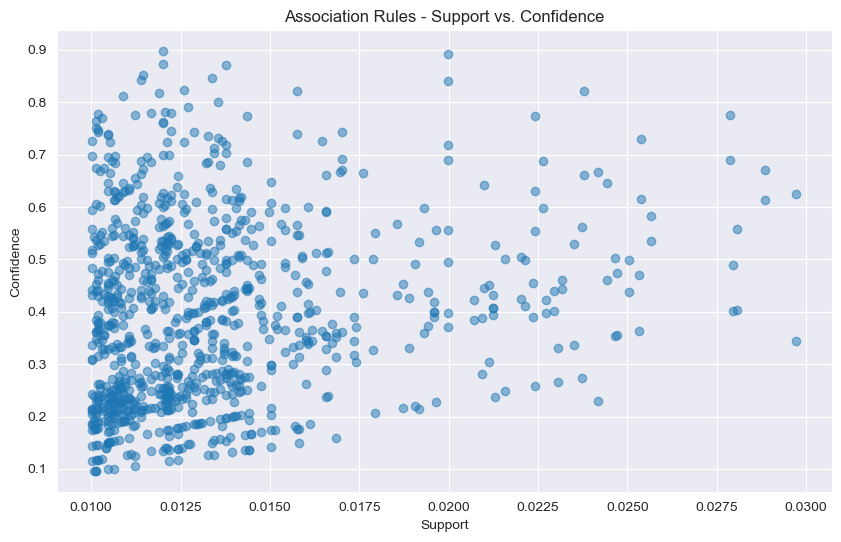

In [13]:
# Scatter plot of association rules
plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules - Support vs. Confidence')
plt.show()

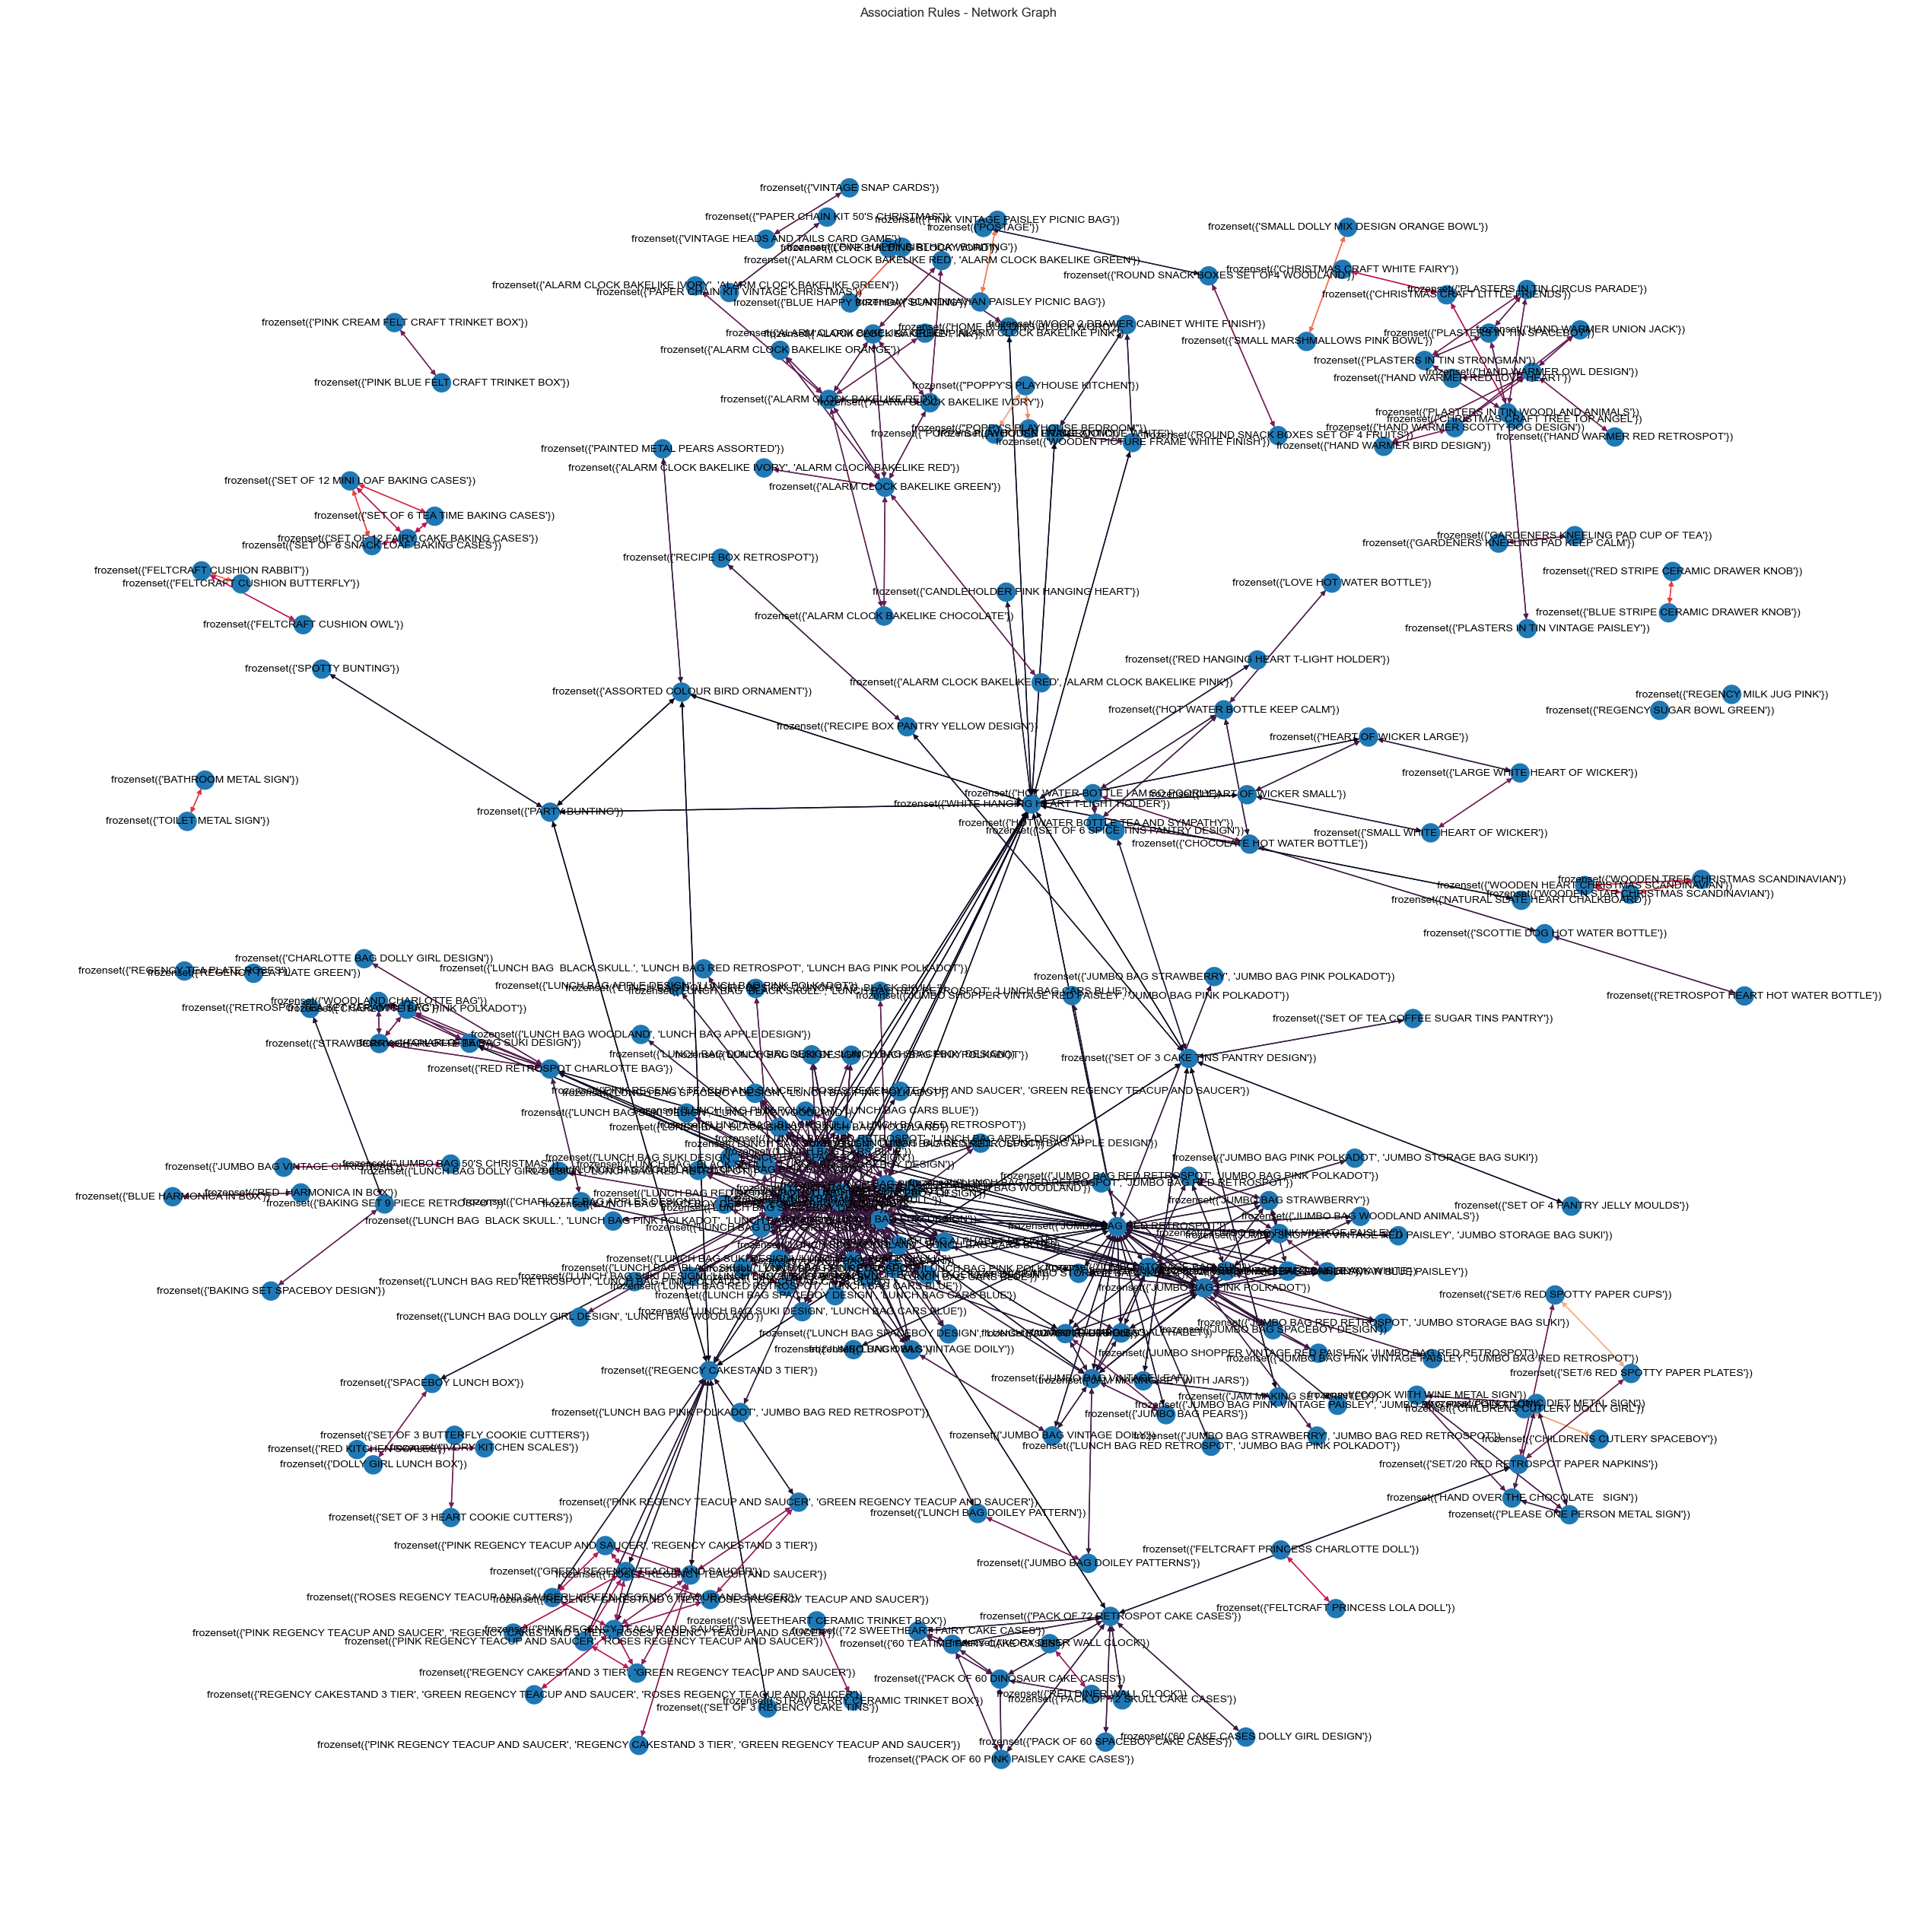

In [14]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes for antecedents and consequents
G.add_nodes_from(rules['antecedents'], color='blue', size=200)
G.add_nodes_from(rules['consequents'], color='red', size=200)

# Add edges between antecedents and consequents
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

# Draw the network graph
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G, k=0.5)
colors = [G[u][v]['weight'] for u, v in G.edges()]
sizes = [300 if 'color' not in node else 100 for node in G.nodes(data=True)]
nx.draw(G, pos, edge_color=colors, node_size=sizes, with_labels=True, font_size=10)
plt.title('Association Rules - Network Graph')
plt.show()

## Business Insights

- Interpreting the association rules in the context of your retail business is a crucial step to gain actionable insights. Here are some guidelines to help you derive meaningful insights from the association rules:

**Product Relationships**

Analyze the antecedents and consequents of the association rules to understand how products are related. For example, if customers who buy Product A also tend to buy Product B, there may be a complementary relationship between the two products.

**Customer Behavior**

Consider what customer behaviors are revealed by the rules. Are there specific patterns of purchasing behavior? Are certain items frequently bought together by a particular group of customers?

**Actionable Insights**

1. Identify opportunities for product bundling. If certain items are frequently purchased together, consider bundling them as a package deal or offering discounts when customers buy both.
2. Develop cross-selling strategies. If customers frequently buy Product X when they purchase Product Y, you can cross-sell these products by recommending them together.
3. Optimize product placement in your store or website. Place related products close to each other to encourage cross-purchases.
4. Personalize recommendations. Use the association rules to provide personalized product recommendations to customers based on their past purchases.

**Frequency and Confidence**

Pay attention to the support, confidence, and lift values of the association rules. High-confidence rules are more reliable, and high-lift rules indicate a strong association.

**Thresholds**

Adjust support and confidence thresholds to filter rules based on their significance. Experiment with different threshold values to refine the rules according to your objectives.

**Feedback Loop**

Implement and test the insights gained from the association rules in your retail strategy. Monitor the impact on sales and customer behavior. Use this feedback loop to continuously improve your strategies.

**Segmentatio**

Consider segmenting your customers based on their purchasing behavior. Are there different groups with distinct preferences? Tailor your strategies to each segment.

**Visualization**

Visualize the insights and relationships discovered through association rules using charts, graphs, and reports. Visual aids can make complex patterns easier to understand.

**Documentation**

Document your findings and insights. Keep a record of which strategies you've implemented and their outcomes. This documentation can serve as a valuable resource for future decision-making.

----

NOTE: By following these guidelines, you can transform the association rules into actionable insights that drive your retail business forward, whether it's through improved product bundling, cross-selling, or enhanced customer experiences.

## Conclusion

In the realm of retail, data-driven insights hold the key to unlocking opportunities for growth and customer satisfaction. Our journey through the Market Basket Analysis project has been a compelling exploration of the power of association rules and their potential to drive strategic decision-making in the retail industry.

Through meticulous data preprocessing, we transformed raw transaction data into a format suitable for uncovering hidden patterns and relationships among products and customer behavior. Leveraging the Apriori algorithm and the mlxtend library, we ventured into the world of frequent itemsets and association rules, unearthing valuable insights that can shape the future of our retail endeavors.

Our odyssey led us through critical stages:

**Exploratory Data Analysis**

We delved into the dataset, visualizing trends and patterns with libraries like Matplotlib and Seaborn. This initial step unveiled the potential hidden within our data, sparking our curiosity and setting the stage for deeper analysis.

**Data Transformation**

To perform Market Basket Analysis, we structured our data into a transaction-level format, a crucial step that allowed us to identify which products were frequently purchased together. Thanks to the Pandas and mlxtend libraries, this transformation was achieved seamlessly.

**Apriori Algorithm**

The Apriori algorithm emerged as our trusted companion in the quest for association rules. We experimented with support and confidence thresholds to generate meaningful rules that reflect customer preferences and product relationships.

**Visualization**

Visualization brought our findings to life. With NetworkX and Matplotlib, we crafted engaging network graphs that vividly illustrated product associations, making complex patterns more comprehensible.

**Business Insights**

Ultimately, the project's true essence lies in its potential to drive real-world decisions. We distilled actionable insights from the association rules, paving the way for strategic product bundling, cross-selling initiatives, and personalized customer recommendations.

----

As we conclude this chapter of our data exploration journey, we are armed with newfound knowledge and a deeper understanding of our retail landscape. The association rules we've uncovered are more than just patterns; they are a gateway to improved customer experiences, increased sales, and optimized retail strategies.

This project has illuminated the path forward—a path that involves data-driven decision-making, continuous experimentation, and a commitment to harnessing the insights concealed within our data. As we move forward, we do so with the conviction that the fusion of data science and retail holds boundless opportunities for innovation and growth.